In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

### Dropping Columns we know we don't want right away and then merging the different csv files to get additional columns we want

In [2]:
df = pd.read_csv("./archive/job_postings.csv")
columns_to_drop = ['expiry', 'skills_desc', 'posting_domain', 'compensation_type', 'sponsored', 'currency', 'listed_time',
                   'job_posting_url', 'application_url', 'application_type', 'closed_time', 'applies', 'views', 'remote_allowed',
                  'original_listed_time', 'description', 'work_type']

# drop columns we know we don't want
df = df.drop(columns=columns_to_drop)

# joining the different data sets
emp_count_df = pd.read_csv('./archive/employee_counts.csv')
emp_count_df = emp_count_df[['company_id', 'employee_count']]
emp_count_df = emp_count_df.drop_duplicates(subset = ['company_id'])

comp_ind = pd.read_csv("./archive/company_industries.csv")
comp_ind = comp_ind.drop_duplicates(subset = ['company_id'])

comp_size = pd.read_csv("./archive/companies.csv")
comp_size = comp_size[['company_id', 'company_size']]
comp_size = comp_size.drop_duplicates(subset = ['company_id'])

skills_abr = pd.read_csv("./archive/job_skills.csv")
skills_abr = skills_abr[['skill_abr', 'job_id']]

# One hot encode skills_abr for each job_id
skills_abr = pd.get_dummies(skills_abr, columns=['skill_abr'])
skills_abr = skills_abr.groupby('job_id').sum().reset_index()

df = df.merge(emp_count_df, how='inner', on='company_id')
df = df.merge(comp_ind,  how='inner', on='company_id')
df = df.merge(comp_size,  how='inner', on='company_id')
df = df.merge(skills_abr,  how='inner', on='job_id')


### Getting rid of null experience level and salaries. Then fixing the salary columns and getting rid of outliers in them

In [3]:
# get rid of null experience level
unique_levels = df['formatted_experience_level'].unique()[1:]
df = df[df['formatted_experience_level'].isin(unique_levels)]

#drop null salaries
df = df.dropna(subset=['pay_period', 'min_salary', 'max_salary'])

# quick verification
print(len(df))
print(df['med_salary'].isna().sum())
print(df['min_salary'].isna().sum())
print(df['max_salary'].isna().sum())
print(df['pay_period'].isna().sum())

3887
3887
0
0
0


In [4]:
# making all pay the same rates
df.loc[df['pay_period'] == 'HOURLY', 'max_salary'] = df['max_salary'] * 40 * 52
df.loc[df['pay_period'] == 'WEEKLY', 'max_salary'] = df['max_salary'] * 52
df.loc[df['pay_period'] == 'MONTHLY', 'max_salary'] = df['max_salary'] * 12

df.loc[df['pay_period'] == 'HOURLY', 'min_salary'] = df['min_salary'] * 40 * 52
df.loc[df['pay_period'] == 'WEEKLY', 'min_salary'] = df['min_salary'] * 52
df.loc[df['pay_period'] == 'MONTHLY', 'min_salary'] = df['min_salary'] * 12

df.loc[df['pay_period'] == 'HOURLY', 'med_salary'] = df['med_salary'] * 40 * 52
df.loc[df['pay_period'] == 'WEEKLY', 'med_salary'] = df['med_salary'] * 52
df.loc[df['pay_period'] == 'MONTHLY', 'med_salary'] = df['med_salary'] * 12

# we know all salaries are annual, so we drop the pay_period column
df = df.drop(columns=['pay_period'])

# impute missing median salary now we have correct rates for min and max
df.loc[df['med_salary'].isna(), 'med_salary'] = (df['max_salary'] + df['min_salary']) / 2
print(df[['med_salary', 'min_salary', 'max_salary']])

# show descriptive analysis for the salaries
print(df[["min_salary","med_salary", "max_salary"]].describe(include="all"))

       med_salary  min_salary  max_salary
18       190000.0    152000.0    228000.0
20        74800.0     59800.0     89800.0
24        74800.0     59800.0     89800.0
29        74800.0     59800.0     89800.0
32        95000.0     76000.0    114000.0
...           ...         ...         ...
14922     98550.0     91900.0    105200.0
14923     95596.8     76481.6    114712.0
14924    100000.0     90000.0    110000.0
14929     44688.8     39686.4     49691.2
14932    122500.0    110000.0    135000.0

[3887 rows x 3 columns]
          min_salary    med_salary    max_salary
count    3887.000000  3.887000e+03  3.887000e+03
mean    86292.504847  1.014130e+05  1.165335e+05
std     47159.940991  5.869503e+04  7.567591e+04
min        15.000000  1.500000e+01  1.500000e+01
25%     52000.000000  5.985555e+04  6.545760e+04
50%     75952.670000  9.000000e+04  1.000000e+05
75%    112493.000000  1.325000e+05  1.500000e+05
max    800000.000000  1.050000e+06  1.300000e+06


In [5]:
# Drop outliers for min and max salary

df = df[df['max_salary'] > 5000]
df = df[df['max_salary'] <= 350000]

df = df[df['min_salary'] > 5000]
df = df[df['min_salary'] <= 350000]

# Drop rows with null columns now that we have salary columns fixed
df = df.dropna()

print(len(df))

# scaling the salary columns. they'll be in 10s of thousands 
df["min_salary"] = df["min_salary"].apply(lambda sal: sal / 10000)
df["max_salary"] = df["max_salary"].apply(lambda sal: sal / 10000)
df["med_salary"] = df["med_salary"].apply(lambda sal: sal / 10000)

3712


### Fixing the location column to conform to state abbreviation or other. Then encoding this column
A graph is included to showcase the distribution of jobs with respect to location

In [6]:
# here we are trying to standardize the location column so we only get the abbreviated state name

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC"}

us_city_to_state= {
        'San': 'CA',
        'Atlanta': 'GA',
        'Grand Rapids': 'MI',
        'Detroit': 'MI',
        'Cincinnati': 'OH',
        'Denver': 'CO',
        'Los Angeles': 'CA',
        'Las Vegas': 'NV',
        'Seattle':'WA',
        'Miami-Fort': 'FL',
        'Chicago': 'IL',
        'Tampa': 'FL',
        'Salt Lake': 'UT',
        'Nashville': 'TN',
        'Buffalo-Niagara': 'NY',
        'Raleigh-Durham-Chapel': 'NC',
        'Huntsville-Decatur-Albertville':'AL',
        'Madison' : 'WI',
        'Minneapolis-St.': 'MN',
        'Dallas-Fort': 'TX',
        'Pittsburgh': 'PA',
        'Houston': 'TX',
        'Orlando': 'FL',
        'Memphis': 'TN',
        'Philadelphia': 'PA',
        'Phoenix': 'AZ',
        'AZ': 'AZ',
        'Charlotte': 'NC',
        'Cleveland':'OH'}

'''
This algorithm attempts to get the state from the location in the abbreviated format.
If it cannot, it lists it as other.
360 locations recovered
'''

locations = df['location'].values
counter = 0
counter2 = 0
for i in range(len(locations)):
    components = locations[i].split(',')
    
    # looked like always "state, US"
    if len(components) > 1 and components[-1].strip() == 'United States':
        counter += 1
        locations[i] = us_state_to_abbrev[components[-2].strip()]
        continue
    
    # checks for city, state abbrev
    loc = components[-1].strip()
    if len(loc) == 2:
        locations[i] = loc
        continue
    
    
    location = components[-1].split()[0].strip()
    if location in us_state_to_abbrev.keys():
        counter2 +=1
        locations[i] = us_state_to_abbrev[location]
        continue  
    elif location in us_city_to_state.keys():
        counter2 +=1
        locations[i] = us_city_to_state[location]
        continue
    
    if len(components[-1].split()) > 1:
        location = components[-1].split()[0].strip() + ' ' + components[-1].split()[1].strip()
        if location in us_state_to_abbrev.keys():
            counter2 +=1
            locations[i] = us_state_to_abbrev[location]
            continue
        elif location in us_city_to_state.keys():
            counter2 +=1
            locations[i] = us_city_to_state[location]
            continue

        location = components[-1].split()[1].strip()
        if location in us_state_to_abbrev.keys():
            counter2 +=1
            locations[i] = us_state_to_abbrev[location]
            continue
        elif location in us_city_to_state.keys():
            counter2 +=1
            locations[i] = us_city_to_state[location]
            continue
            
    locations[i] = 'other'

        
unique_locations = np.unique(locations)
        
df['location'] = locations

print(f'total locations recovered {counter+counter2}')
print(f'Unique locations: {unique_locations}')

total locations recovered 444
Unique locations: ['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'WA' 'WI' 'WV' 'WY' 'other']


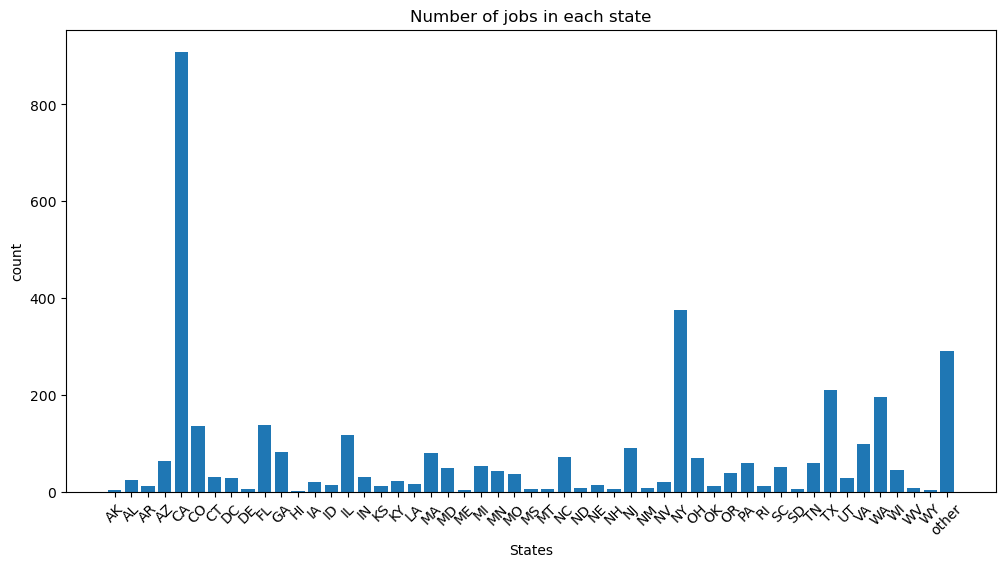

In [7]:
# unique_locations the label, values is corresponding values
values = df.groupby('location')['location'].count()

# plot bar graph to see distribution of states
plt.figure(figsize=(12,6))
plt.bar(unique_locations, values)
plt.tick_params(axis='x', rotation=45)
plt.xlabel('States')
plt.ylabel('count')
plt.title('Number of jobs in each state')
plt.show()

In [8]:
# encoding location
le = LabelEncoder()
le.fit(unique_locations)
list(le.classes_)
locations = le.transform(locations)
df['location'] = locations

#encode title
le = LabelEncoder()
titles = df['title'].values
unique_titles = np.unique(titles)
le.fit(unique_titles)
list(le.classes_)
titles = le.transform(titles)
df['title'] = titles

### Encoded formatted_experience_level and formatted_work_type. Grouped the employee counts into bins

In [9]:
# fix formatted_experience_level column and ordinal encode

# ['Associate' 'Mid-Senior level' 'Entry level' 'Executive' 'Director' 'Internship'] 
# We want to combine Internship with entry, and Executive, Director into management
experience_lvls = ['Entry level', 'Associate', 'Mid-Senior level', 'Management']
fel_column = df['formatted_experience_level'].values
for i in range(len(fel_column)):
    level = fel_column[i].strip()
    if level in experience_lvls:
        fel_column[i] = level
        continue
    
    if level == 'Internship':
        fel_column[i] = 'Entry level'
    else:
        fel_column[i] = 'Management'

# set updated experience column
df['formatted_experience_level'] = fel_column
print(df['formatted_experience_level'].unique())
print(df.groupby('formatted_experience_level')['formatted_experience_level'].count())

#ordinal encode
for i in range(len(fel_column)):
    level = fel_column[i]
    fel_column[i] = experience_lvls.index(level)
df['formatted_experience_level'] = fel_column

print(df['formatted_experience_level'].unique())
print(df.groupby('formatted_experience_level')['formatted_experience_level'].count())

['Management' 'Entry level' 'Mid-Senior level' 'Associate']
formatted_experience_level
Associate            550
Entry level         1057
Management           245
Mid-Senior level    1860
Name: formatted_experience_level, dtype: int64
[3 0 2 1]
formatted_experience_level
0    1057
1     550
2    1860
3     245
Name: formatted_experience_level, dtype: int64


In [10]:
# fix formatted_work_type column and ordinal encode

# ['Full-time' 'Contract' 'Part-time' 'Temporary' 'Other' 'Internship']
# we'll group temporary with part-time and other with contract
work_type = ['Internship', 'Part-time', 'Contract', 'Full-time'] 
work_type_col = df['formatted_work_type'].values

for i in range(len(work_type_col)):
    type_ = work_type_col[i].strip()
    if type_ in work_type:
        work_type_col[i] = type_
        continue
    
    if type_ == 'Temporary':
        work_type_col[i] = 'Part-time'
    else:
        work_type_col[i] = 'Contract'

# set updated experience column
df['formatted_work_type'] = work_type_col
print(df['formatted_work_type'].unique())
print(df.groupby('formatted_work_type')['formatted_work_type'].count())

#ordinal encode
for i in range(len(work_type_col)):
    type_ = work_type_col[i]
    work_type_col[i] = work_type.index(type_)
df['formatted_work_type'] = work_type_col


print(df['formatted_work_type'].unique())
print(df.groupby('formatted_work_type')['formatted_work_type'].count())

['Full-time' 'Part-time' 'Contract' 'Internship']
formatted_work_type
Contract       511
Full-time     3055
Internship      10
Part-time      136
Name: formatted_work_type, dtype: int64
[3 1 2 0]
formatted_work_type
0      10
1     136
2     511
3    3055
Name: formatted_work_type, dtype: int64


In [11]:
# encode employee count column based off these groupings
def interval(value):
    k = 1000
    if value < 10*k:
        return 0
    elif value >= 10*k and value < 20*k:
        return 1
    elif value >= 20*k and value < 30*k:
        return 2
    elif value >= 30*k and value < 40*k:
        return 3
    elif value >= 40*k and value < 50*k:
        return 4
    elif value >= 50*k and value < 60*k:
        return 5
    elif value >= 60*k and value < 70*k:
        return 6
    elif value >= 70*k and value < 80*k:
        return 7
    elif value >= 80*k and value < 90*k:
        return 8
    elif value >= 90*k and value < 100*k:
        return 9
    elif value >= 100*k:
        return 10

df["employee_count"] = df["employee_count"].apply(interval)

In [12]:
# create boolean column that specifies whether the respective salaries are above average
above_avg_min = []
above_avg_med = []
above_avg_max = []

min_ = df['min_salary'].values
med_ = df['med_salary'].values
max_ = df['max_salary'].values

min_avg = np.mean(min_)
max_avg = np.mean(max_)
med_avg = np.mean(med_)


for sal in min_:
    if sal >= min_avg:
        above_avg_min.append(1)
    else:
        above_avg_min.append(0)
        
for sal in med_:
    if sal >= med_avg:
        above_avg_med.append(1)
    else:
        above_avg_med.append(0)
        
for sal in max_:
    if sal >= max_avg:
        above_avg_max.append(1)
    else:
        above_avg_max.append(0)
        
df['above_avg_min'] = above_avg_min
df['above_avg_med'] = above_avg_med
df['above_avg_max'] = above_avg_max


#double check we did this correctly
print(df[['above_avg_min', 'above_avg_med', 'above_avg_max']])


       above_avg_min  above_avg_med  above_avg_max
18                 1              1              1
20                 0              0              0
24                 0              0              0
29                 0              0              0
32                 0              0              1
...              ...            ...            ...
14922              1              0              0
14923              0              0              1
14924              1              1              0
14929              0              0              0
14932              1              1              1

[3712 rows x 3 columns]


### Graphing section
Here we create a lot of visuals for EDA

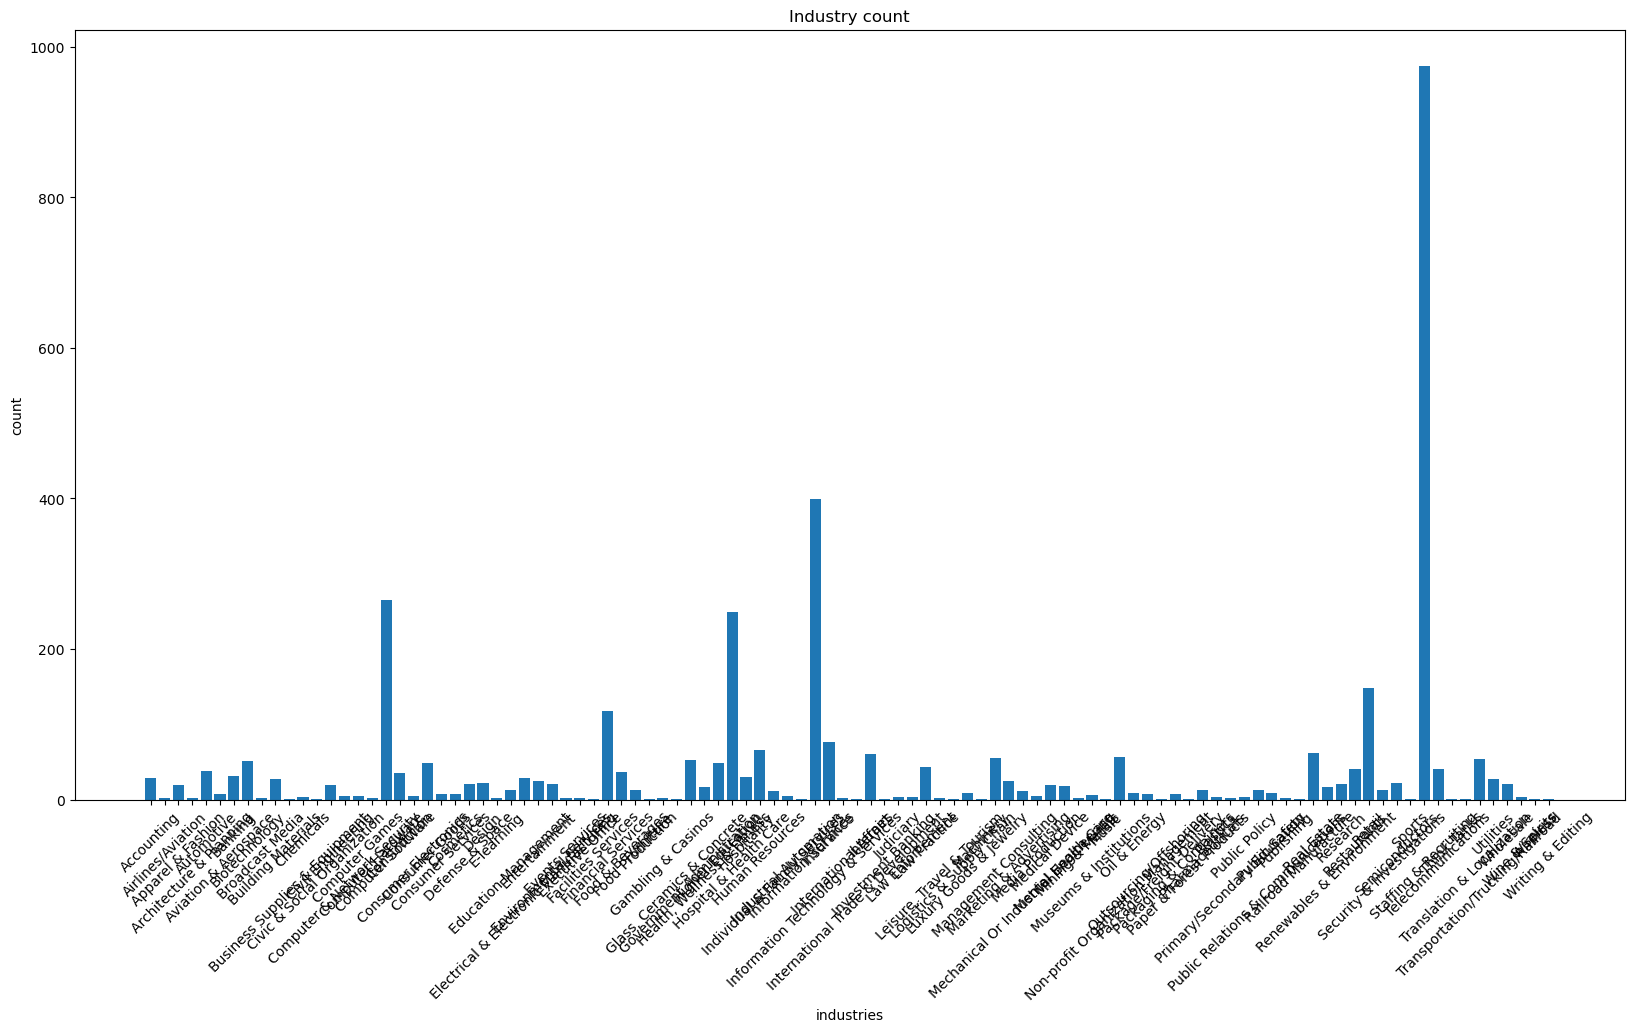

In [13]:
# graph industry count
counts = df.groupby('industry')['industry'].count().values
unique_industries = list(df.groupby('industry')['industry'].count().index)
industries = df['industry'].values

plt.figure(figsize=(20,10))
plt.bar(unique_industries, counts)
plt.tick_params(axis='x', rotation=45)
plt.xlabel('industries')
plt.ylabel('count')
plt.title('Industry count')
plt.show()

# encode industries 
le = LabelEncoder()
le.fit(unique_industries)
list(le.classes_)
industries = le.transform(industries)
df['industry'] = industries

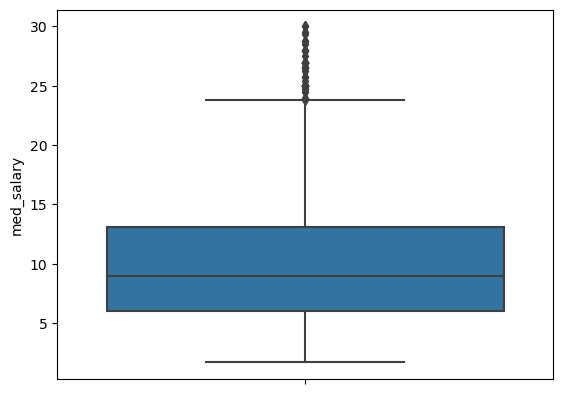

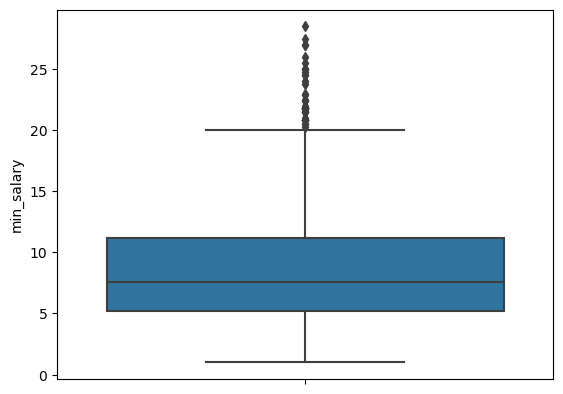

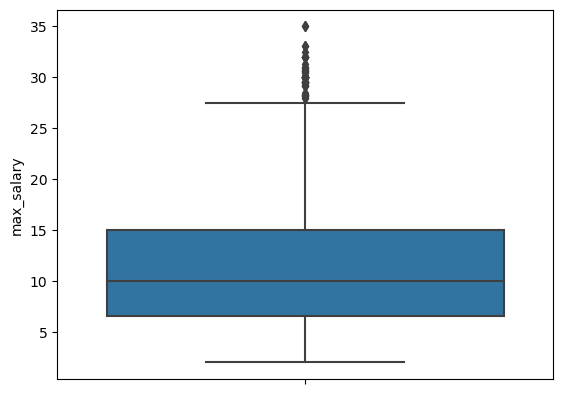

min_salary    40
max_salary    56
med_salary    40
dtype: int64

In [14]:
# try to get a guage of the outliers and how many they are for salaries
sns.boxplot(y=df['med_salary'])
plt.show()

sns.boxplot(y=df['min_salary'])
plt.show()

sns.boxplot(y=df['max_salary'])
plt.show()

sal_df = df[['min_salary', 'max_salary', 'med_salary']]
Q1 = sal_df.quantile(0.25)
Q3 = sal_df.quantile(0.75)
IQR = Q3 - Q1

# get number of remaining outliers
((sal_df < (Q1 - 1.5 * IQR)) | (sal_df > (Q3 + 1.5 * IQR))).sum()


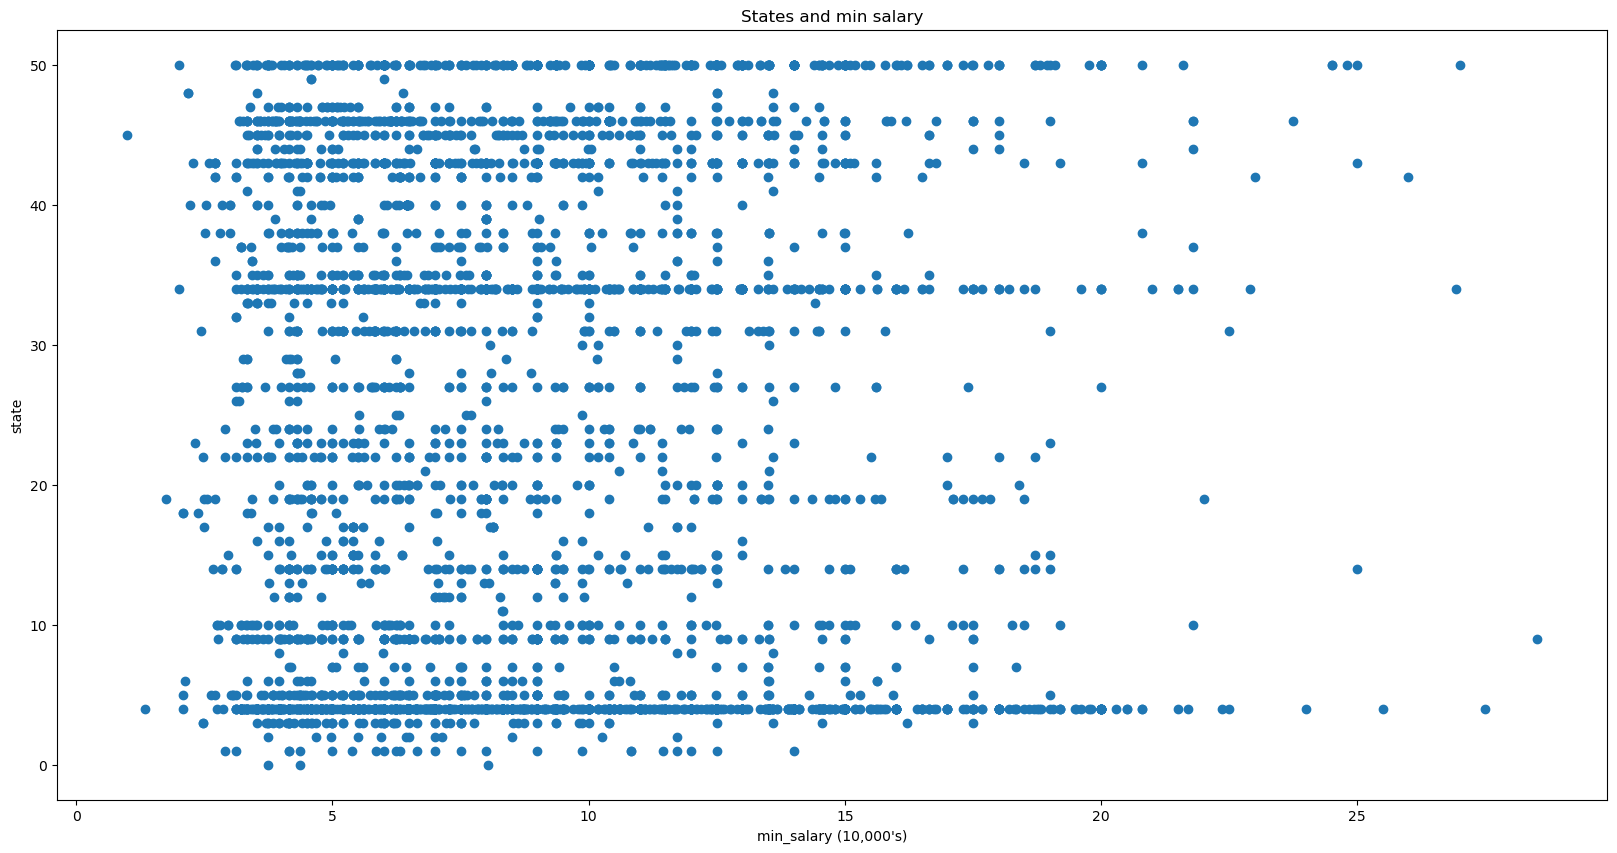

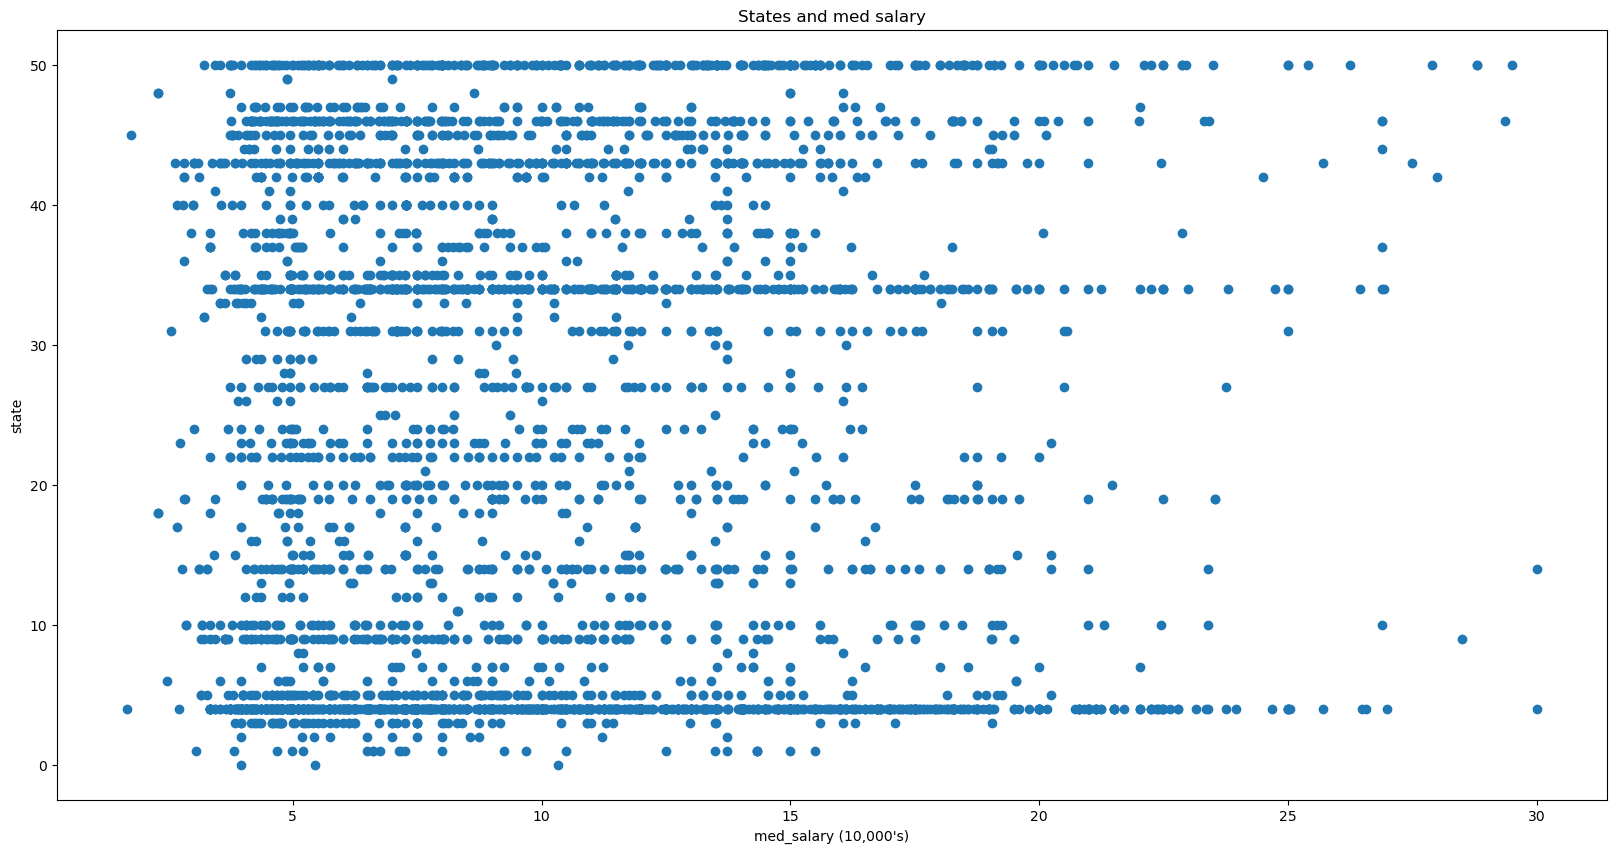

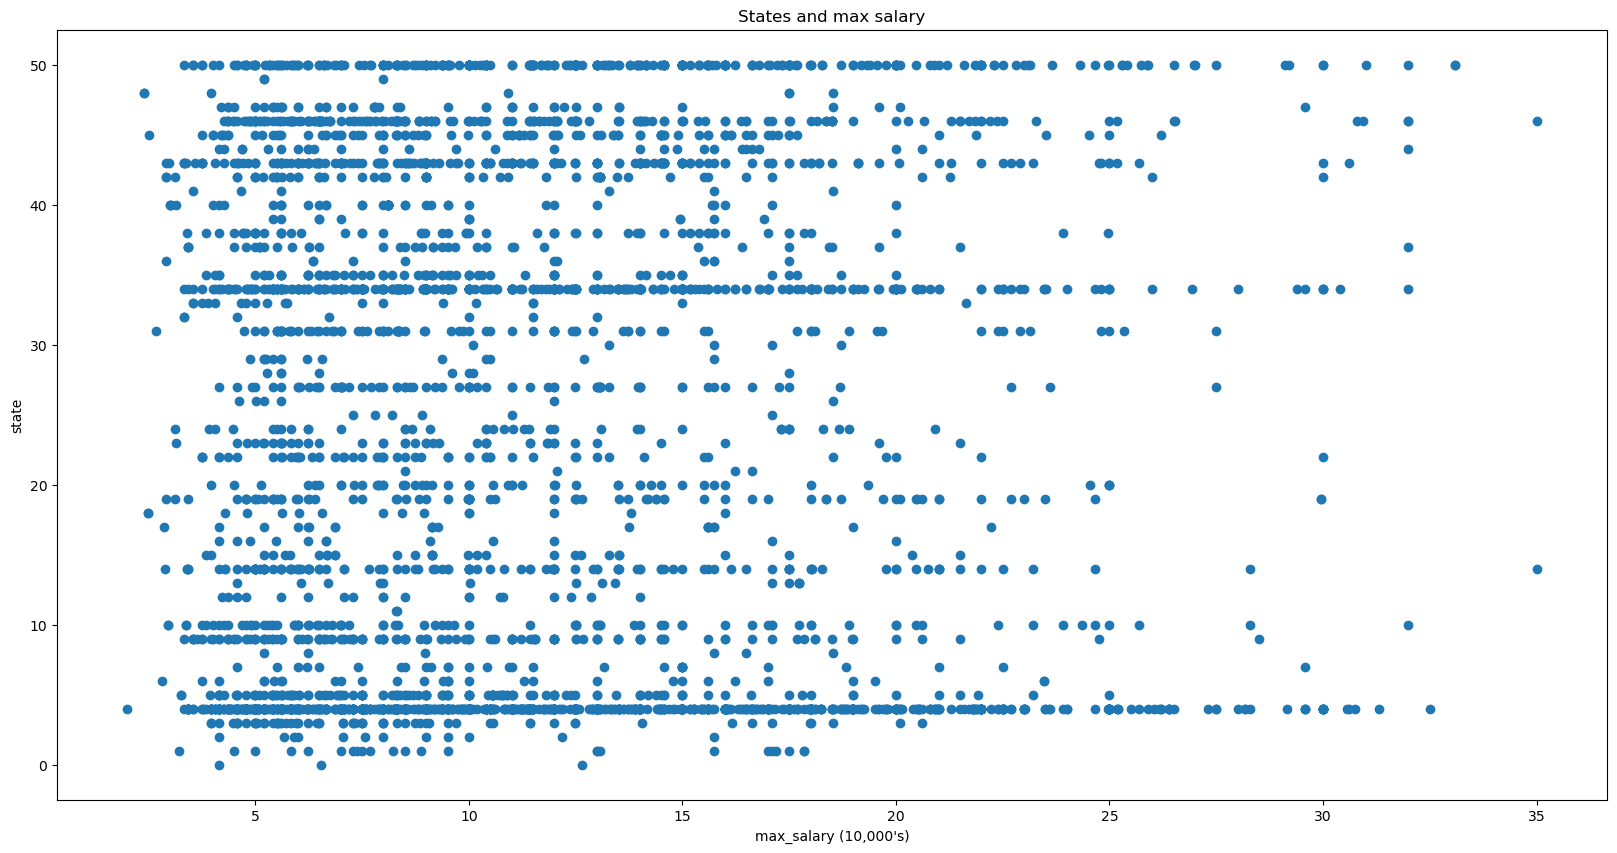

In [15]:
# see how the states impact the salaries
cities = df['location'].values
min_salary = df['min_salary'].values
max_salary = df['max_salary'].values 
med_salary = df['med_salary'].values

plt.figure(figsize=(20,10))
plt.title('States and min salary')
plt.scatter(min_salary, cities)
plt.ylabel('state')
plt.xlabel('min_salary (10,000\'s)')
plt.show()

plt.figure(figsize=(20,10))
plt.scatter(med_salary, cities)
plt.ylabel('state')
plt.xlabel('med_salary (10,000\'s)')
plt.title('States and med salary')
plt.show()

plt.figure(figsize=(20,10))
plt.scatter(max_salary, cities)
plt.ylabel('state')
plt.xlabel('max_salary (10,000\'s)')
plt.title('States and max salary')
plt.show()

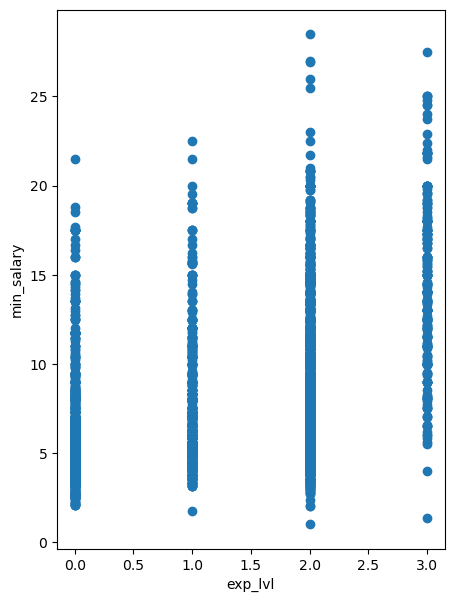

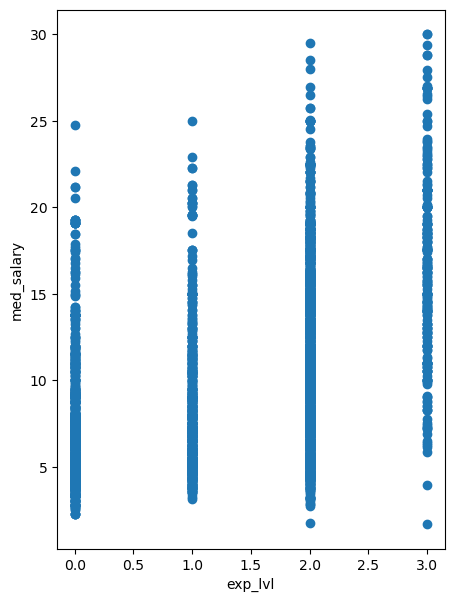

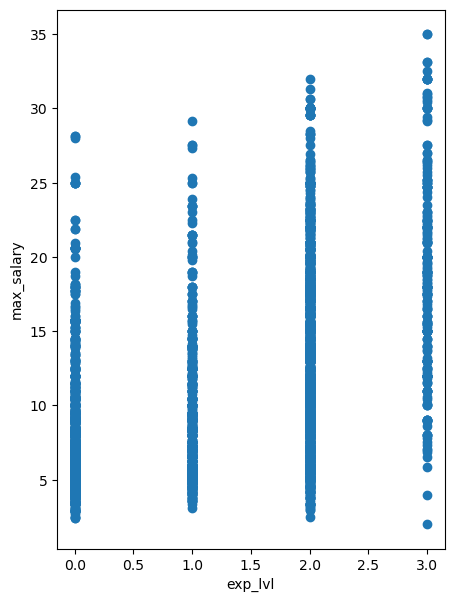

In [16]:
# see how experience level impacts the salary
exp_lvl = df['formatted_experience_level'].values
min_salary = df['min_salary'].values
med_salary = df['med_salary'].values
max_salary = df['max_salary'].values

plt.figure(figsize=(5, 7))
plt.scatter(exp_lvl, min_salary)
plt.ylabel('min_salary')
plt.xlabel('exp_lvl')
plt.show()

plt.figure(figsize=(5, 7))
plt.scatter(exp_lvl, med_salary)
plt.ylabel('med_salary')
plt.xlabel('exp_lvl')
plt.show()

plt.figure(figsize=(5, 7))
plt.scatter(exp_lvl, max_salary)
plt.ylabel('max_salary')
plt.xlabel('exp_lvl')
plt.show()

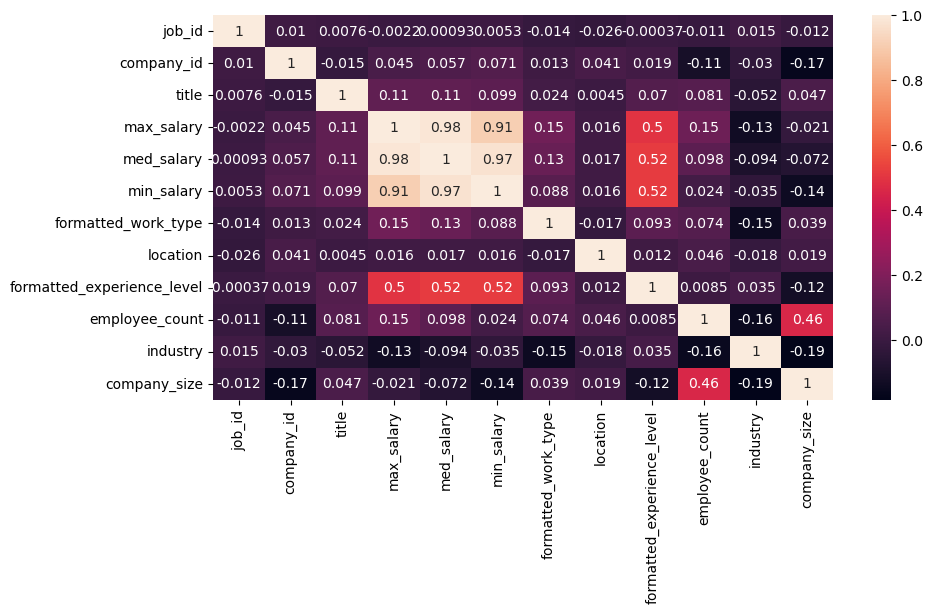

In [17]:
# we're excluding skills
matrix_df = df.loc[:, :'company_size']

plt.figure(figsize=(10, 5))
correlation_mat = matrix_df.corr()
sns.heatmap(correlation_mat, annot=True)
plt.show()

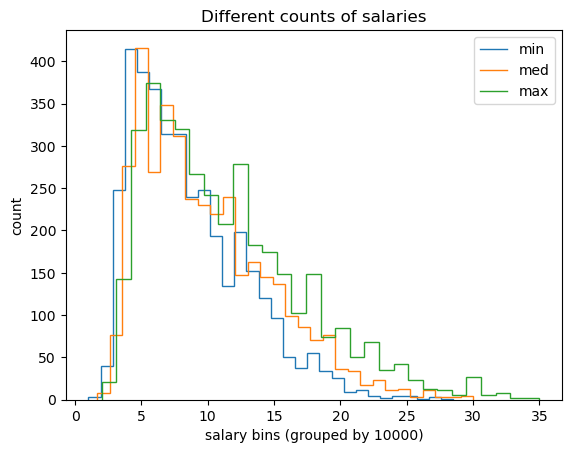

In [18]:
#histogram 
counts, bins = np.histogram(df['min_salary'].values, bins = 30)
plt.stairs(counts, bins, label='min')
counts, bins = np.histogram(df['med_salary'].values, bins = 30)
plt.stairs(counts, bins, label='med')
counts, bins = np.histogram(df['max_salary'].values, bins = 30)
plt.stairs(counts, bins, label='max')
plt.ylabel('count')
plt.xlabel('salary bins (grouped by 10000)')
plt.legend()
plt.title('Different counts of salaries')
plt.show()

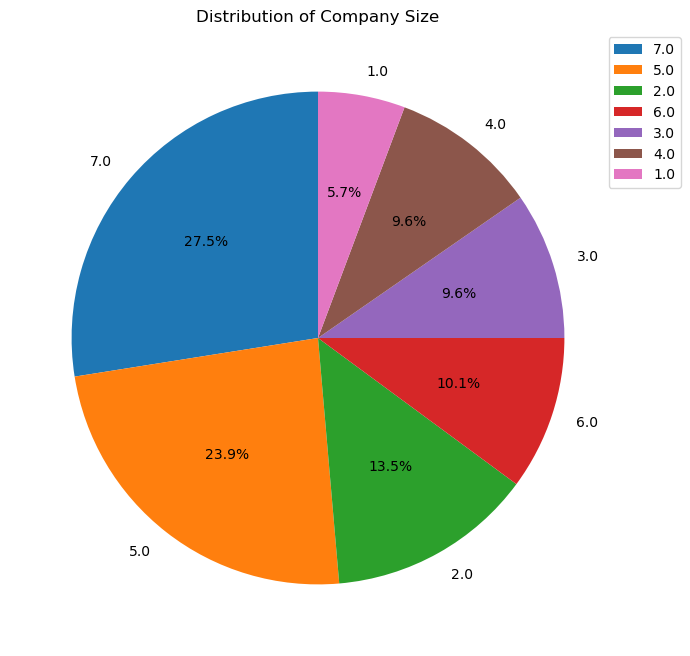

In [19]:
flat_series = df["company_size"].values.flatten()
frequency_counts = pd.Series(flat_series).value_counts()
label = frequency_counts.index

plt.figure(figsize=(8, 8))
plt.pie(frequency_counts, labels=label, autopct='%1.1f%%', startangle=90)
plt.legend(label, loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Distribution of Company Size')
plt.show()